# Predicting 13C NMR shifts

Based on the [nmrshiftdb2](https://nmrshiftdb.nmr.uni-koeln.de/nmrshiftdb/media-type/html/user/anon/page/default.psml/js_pane/portal/js_pane/P-Help;jsessionid=B237E9AB49EB45D0F9E560719C792E4A?URL=t1.html#about) NMR database for organic structures and their nuclear magnetic resonance (nmr) spectra.

Inspiration taken from:
- Paper at https://browse.arxiv.org/pdf/2304.03361.pdf
- Associated [python code](https://colab.research.google.com/drive/1yKTRjpWzR8T199eCokuJfd9Y5o2oNtPp#scrollTo=wha6jaKTZlUX)
- [“Prediction of 1H and 13C NMR Chemical Shifts of Small Molecules Using Machine Learning”](https://era.library.ualberta.ca/items/48539bc5-c67e-47f2-97f4-afe6594b6dca), a Master thesis by Zinat Sayeeda

In [1]:
import math
import mendeleev
import os
import pandas as pd
import random
import requests

# Specify a seed, so pseudo-random numbers are the same and the notebook is reproducible
random.seed("Call me Ishmael.")

In [2]:
DATA_URL = "https://sourceforge.net/projects/nmrshiftdb2/files/data/nmrshiftdb2.nmredata.sd/download"
DATA_FILE = "nmrshiftdb2.nmredata.sd"

if not os.path.isfile(DATA_FILE):
    print("Downloading data file (large file: 200 MB)")
    r = requests.get(DATA_URL, allow_redirects=True)
    with open(DATA_FILE, "wb") as f:
        f.write(r.content)
        print("File saved")
else:
    print("Data file already present")

Data file already present


In [3]:
from rdkit import Chem
molecules = list(Chem.SDMolSupplier(DATA_FILE))
print(f"{len(molecules)} molecules read")

[15:25:27] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:25:27] ERROR: Could not sanitize molecule ending on line 2496171
[15:25:27] ERROR: Explicit valence for atom # 4 N, 4, is greater than permitted
[15:25:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:25:27] ERROR: Could not sanitize molecule ending on line 2496259
[15:25:27] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
[15:25:27] Explicit valence for atom # 3 H, 3, is greater than permitted
[15:25:27] ERROR: Could not sanitize molecule ending on line 2569602
[15:25:27] ERROR: Explicit valence for atom # 3 H, 3, is greater than permitted
[15:25:27] Explicit valence for atom # 3 H, 3, is greater than permitted
[15:25:27] ERROR: Could not sanitize molecule ending on line 2569689
[15:25:27] ERROR: Explicit valence for atom # 3 H, 3, is greater than permitted
[15:25:27] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:25:27] ERROR: Could not sanitize mo

50217 molecules read


[15:25:29] Explicit valence for atom # 15 B, 4, is greater than permitted
[15:25:29] ERROR: Could not sanitize molecule ending on line 5557956
[15:25:29] ERROR: Explicit valence for atom # 15 B, 4, is greater than permitted
[15:25:29] Explicit valence for atom # 15 B, 4, is greater than permitted
[15:25:29] ERROR: Could not sanitize molecule ending on line 5558091
[15:25:29] ERROR: Explicit valence for atom # 15 B, 4, is greater than permitted
[15:25:29] Explicit valence for atom # 21 B, 4, is greater than permitted
[15:25:29] ERROR: Could not sanitize molecule ending on line 5694153
[15:25:29] ERROR: Explicit valence for atom # 21 B, 4, is greater than permitted
[15:25:29] Explicit valence for atom # 21 B, 4, is greater than permitted
[15:25:29] ERROR: Could not sanitize molecule ending on line 5694321
[15:25:29] ERROR: Explicit valence for atom # 21 B, 4, is greater than permitted
[15:25:29] Explicit valence for atom # 0 I, 7, is greater than permitted
[15:25:29] ERROR: Could not san

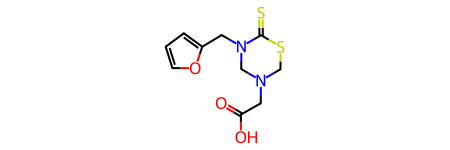

In [4]:
molecules[19]

In [5]:
molecules[19].GetProp("NMREDATA_ASSIGNMENT")

's0, 46.6, 12\\\ns1, 50.4, 14\\\ns2, 58.5, 4\\\ns3, 69.0, 2\\\ns4, 109.7, 10\\\ns5, 110.6, 11\\\ns6, 143.0, 7\\\ns7, 148.7, 9\\\ns8, 170.4, 15\\\ns9, 191.6, 6\\'

In [6]:
molecules[19].GetPropsAsDict()

{'NMREDATA_VERSION': '1.1\\',
 'NMREDATA_SOLVENT': 'Unreported\\',
 'NMREDATA_ASSIGNMENT': 's0, 46.6, 12\\\ns1, 50.4, 14\\\ns2, 58.5, 4\\\ns3, 69.0, 2\\\ns4, 109.7, 10\\\ns5, 110.6, 11\\\ns6, 143.0, 7\\\ns7, 148.7, 9\\\ns8, 170.4, 15\\\ns9, 191.6, 6\\',
 'NMREDATA_INCHI': 'InChI=1S/C10H12N2O3S2/c13-9(14)5-11-6-12(10(16)17-7-11)4-8-2-1-3-15-8/h1-3H,4-7H2,(H,13,14)/i1+0H,2+0H,3+0H,4+0H2,5+0H2,6+0H2,7+0H2,8+0,9+0,10+0,11+0,12+0,13+0,14+0,15+0,16+0,17+0/hH',
 'NMREDATA_LEVEL': '1\\',
 'NMREDATA_ID': 'Doi=10.18716/nmrshiftdb2/2203\\\nDB_ID=2203\\',
 'NMREDATA_1D_13C': 'Spectrum_Location=molecule/2203\\\nLarmor=0.0\\\n46.6, L=s0\\\n50.4, L=s1\\\n58.5, L=s2\\\n69.0, L=s3\\\n109.7, L=s4\\\n110.6, L=s5\\\n143.0, L=s6\\\n148.7, L=s7\\\n170.4, L=s8\\\n191.6, L=s9\\',
 'NMREDATA_SMILES': 'N1(C(N(C(SC1=S)([H])[H])C(C(O[H])=O)([H])[H])([H])[H])C(C=2OC(=C(C2[H])[H])[H])([H])[H]'}

In [7]:
def extractNMRisotopes(mol):
    if not mol:
        return []
    return [x for x in mol.GetPropNames() if x.startswith("NMREDATA_1D_")]

nmr = [extractNMRisotopes(mol) for mol in molecules]

In [8]:
nmr[0:50]

[['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C#2', 'NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C#2', 'NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C#2', 'NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C#2', 'NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C'],
 ['NMREDATA_1D_13C#2',
  'NMREDATA_1D_13C#4',
  'NMREDATA_

In [9]:
def identifyIsotope(x):
    x = x.replace("NMREDATA_1D_", "")
    if "#" in x:
        x = x.split("#")[0]
    return x

nmr = [identifyIsotope(iso) for isotopes in nmr for iso in isotopes]

In [10]:
pd.DataFrame(nmr).value_counts()

13C      42405
1H       17479
19F       1066
11B        316
17O        134
15N         84
195Pt       57
29Si        46
31P         46
73Ge        18
33S          8
Name: count, dtype: int64

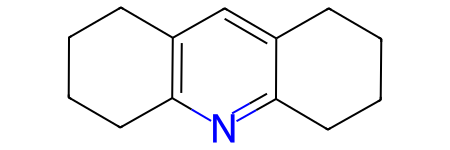

In [11]:
molecules[48]

In [12]:
def analyzeSpectrum(mol):
    spectrum = mol.GetProp("NMREDATA_1D_13C")
    assign = mol.GetProp("NMREDATA_ASSIGNMENT")

    # Get a list of peaks
    peaks = {}
    for line in spectrum.split("\\"):
        if "L=" in line:
            shift = line.split(",")[0].strip()
            label = line.split(",")[1].replace("L=", "").strip()
            peaks[label] = shift
    print("Peaks:")
    print(peaks)

    assignments = {}
    # Get a list of assignments
    for line in assign.split("\\"):
        arr = line.split(",")
        if len(arr) > 2:
            label = arr[0].strip()
            shift = arr[1].strip()
            atoms = [x.strip() for x in arr[2:]]
            assignments[label] = (shift, atoms)
    print("Assignments:")
    print(assignments)

analyzeSpectrum(molecules[58])

Peaks:
{'s0': '34.05', 's1': '91.91', 's2': '117.21', 's3': '121.46', 's4': '123.27', 's5': '127.39', 's6': '127.6', 's7': '128.4', 's8': '128.98', 's9': '129.3', 's10': '131.29', 's11': '131.39', 's12': '132.24', 's13': '141.41', 's14': '145.34', 's15': '153.0', 's16': '193.28'}
Assignments:
{'s0': ('34.05', ['43', '45']), 's1': ('91.91', ['25', '30']), 's2': ('117.21', ['23', '32']), 's3': ('121.46', ['18', '29']), 's4': ('123.27', ['21', '38']), 's5': ('127.39', ['2', '40']), 's6': ('127.6', ['6', '12']), 's7': ('128.4', ['5', '7', '11', '13']), 's8': ('128.98', ['19', '37']), 's9': ('129.3', ['4', '8', '10', '14']), 's10': ('131.29', ['17', '28']), 's11': ('131.39', ['22', '33']), 's12': ('132.24', ['1', '41']), 's13': ('141.41', ['3', '9']), 's14': ('145.34', ['20', '34']), 's15': ('153.0', ['16', '27']), 's16': ('193.28', ['24', '31']), 's17': ('33.7', ['43', '45']), 's18': ('94.3', ['25', '30']), 's19': ('109.35', ['23', '32']), 's20': ('119.7', ['18', '29']), 's21': ('124.5', [

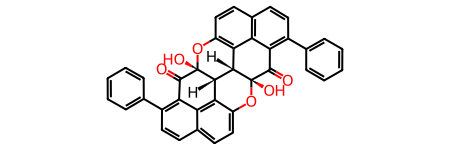

In [13]:
molecules[58]

In [14]:
# Sometimes we have assignments for peaks that are not 13C, or the 13C is not in the first record
analyzeSpectrum(molecules[48])

Peaks:
{'s0': '129.1', 's1': '137.3', 's9': '153.9'}
Assignments:
{'s0': ('129.1', ['10']), 's1': ('137.3', ['9']), 's2': ('153.9', ['8']), 's3': ('22.9', ['1', '13']), 's4': ('23.2', ['2', '12']), 's5': ('28.3', ['4', '14']), 's6': ('32.2', ['3', '11']), 's7': ('129.2', ['6', '10']), 's8': ('137.4', ['9']), 's9': ('153.9', ['5', '8']), 's10': ('1.769', ['28']), 's11': ('1.859', ['26']), 's12': ('2.683', ['30']), 's13': ('2.848', ['24']), 's14': ('7.019', ['23'])}


In [15]:
def analyzeSpectrumSmarter(mol, debug=False):
    if not mol:
        return None
    spectra = [mol.GetProp(x) for x in mol.GetPropNames() if "NMREDATA_1D_13C" in x]
    if debug:
        print(f"Spectra found: {len(spectra)}")
    if len(spectra) == 0:
        return None
    assign = mol.GetProp("NMREDATA_ASSIGNMENT")

    # Get a list of peaks
    peaks = {}
    for spectrum in spectra:
        for line in spectrum.split("\\"):
            if "L=" in line:
                shift = line.split(",")[0].strip()
                label = line.split(",")[1].replace("L=", "").strip()
                peaks[label] = shift
    if debug:
        print("Peaks:")
        print(peaks)

    assignments = {}
    # Get a list of assignments
    for line in assign.split("\\"):
        arr = line.split(",")
        if len(arr) > 2:
            label = arr[0].strip()
            shift = arr[1].strip()
            atoms = [x.strip() for x in arr[2:]]
            assignments[label] = (shift, atoms)
    if debug:
        print("Assignments:")
        print(assignments)

    out = []
    for label, shift in peaks.items():
        if label in assignments:
            atoms = assignments[label][1]
            # Convert the shift to a float value and the atom indices to integers
            out.append((float(shift), [int(at) for at in atoms]))

    return out

analyzeSpectrumSmarter(molecules[48], debug=True)

Spectra found: 2
Peaks:
{'s3': '22.9', 's4': '23.2', 's5': '28.3', 's6': '32.2', 's7': '129.2', 's8': '137.4', 's9': '153.9', 's0': '129.1', 's1': '137.3'}
Assignments:
{'s0': ('129.1', ['10']), 's1': ('137.3', ['9']), 's2': ('153.9', ['8']), 's3': ('22.9', ['1', '13']), 's4': ('23.2', ['2', '12']), 's5': ('28.3', ['4', '14']), 's6': ('32.2', ['3', '11']), 's7': ('129.2', ['6', '10']), 's8': ('137.4', ['9']), 's9': ('153.9', ['5', '8']), 's10': ('1.769', ['28']), 's11': ('1.859', ['26']), 's12': ('2.683', ['30']), 's13': ('2.848', ['24']), 's14': ('7.019', ['23'])}


[(22.9, [1, 13]),
 (23.2, [2, 12]),
 (28.3, [4, 14]),
 (32.2, [3, 11]),
 (129.2, [6, 10]),
 (137.4, [9]),
 (153.9, [5, 8]),
 (129.1, [10]),
 (137.3, [9])]

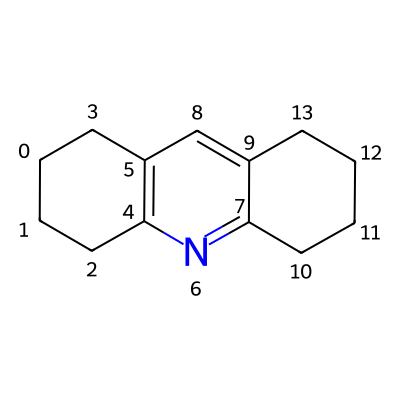

In [16]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400,400
molecules[48]

Seems logical, but we will have to be careful about the shift between zero-based and one-based numbering of atoms.

In [17]:
nmrdata = []
for mol in molecules:
    data = analyzeSpectrumSmarter(mol)
    if data:
        nmrdata.append((data,mol))

In [18]:
len(nmrdata)

37709

In [19]:
allshifts = [peak[0] for data in nmrdata for peak in data[0]]
len(allshifts)

399985

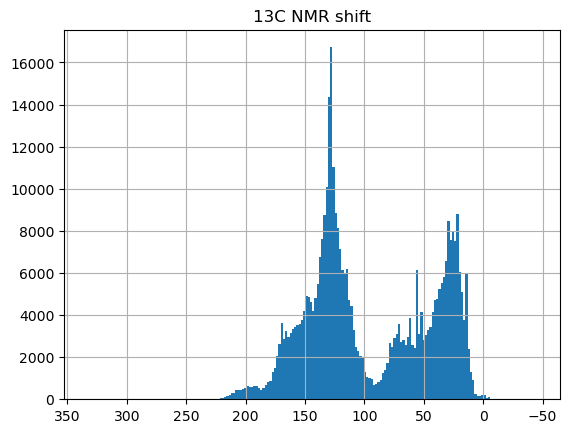

In [20]:
ax = pd.DataFrame(allshifts, columns=["13C NMR shift"]).hist(bins=200)
ax[0][0].invert_xaxis()

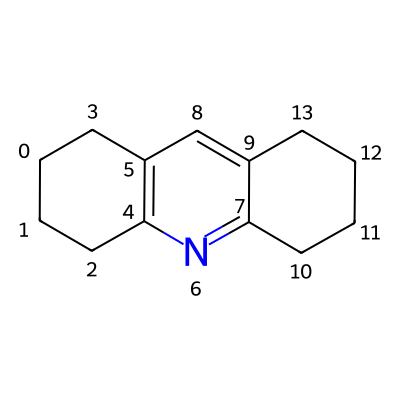

In [21]:
molecules[48]

In [22]:
molecules[48].GetAtoms()[7].GetNeighbors()

(<rdkit.Chem.rdchem.Atom at 0x146c80f90>,
 <rdkit.Chem.rdchem.Atom at 0x146c81070>)

In [23]:
def min_max_avg_stddev(values):
    """
    For a list of values, return the minimum, maximum, average, and standard-deviation as floats.
    """
    n = len(values)
    avg = float(sum(values)) / n
    stddev = math.sqrt(sum((x - avg)**2 for x in values) / n) 
    return [float(min(values)), float(max(values)), avg, stddev]

def generateDescriptors(mol, atom):
    at = mol.GetAtoms()[atom]
    neigh = at.GetNeighbors()

    neigh_z = [x.GetAtomicNum() for x in neigh]
    neigh_formalcharge = [x.GetFormalCharge() for x in neigh]
    neigh_arom = [0 if x.GetIsAromatic() else 1 for x in neigh]
    neigh_electroneg = [mendeleev.element(z).en_pauling for z in neigh_z]
    neigh_electronaff = [mendeleev.element(z).electron_affinity for z in neigh_z]
    
    return [str(at.GetHybridization()),
            at.GetAtomicNum(),
            at.GetIsAromatic(),
            at.GetTotalNumHs(),
            at.GetFormalCharge(),
            *min_max_avg_stddev(neigh_z),
            *min_max_avg_stddev(neigh_formalcharge),
            *min_max_avg_stddev(neigh_arom),
            *min_max_avg_stddev(neigh_electroneg),
            *min_max_avg_stddev(neigh_electronaff),
           ]

In [24]:
generateDescriptors(molecules[48], 7)

['SP2',
 6,
 True,
 0,
 0,
 6.0,
 7.0,
 6.333333333333333,
 0.4714045207910317,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.3333333333333333,
 0.4714045207910317,
 2.55,
 3.04,
 2.7133333333333334,
 0.23098821518760562,
 -1.4,
 1.262119,
 0.374746,
 1.2549349314837004]

In [25]:
%%time

alldata = []
nerrors = 0
for peaks, mol in nmrdata[:30]:
    for shift, atoms in peaks:
        for atom in atoms:
            # Atoms are numbered from 1 in the NMR assignment, but start at 0 for RDKit
            try:
                alldata.append([shift, *generateDescriptors(mol, atom-1)])
            except:
                # Sometimes we fail, because NMR assignment is invalid (references atoms that do not exist)
                nerrors += 1

print(f"Number of records generated: {len(alldata)}")
print(f"Number of errors: {nerrors}")

Number of records generated: 629
Number of errors: 6
CPU times: user 3min 5s, sys: 2.52 s, total: 3min 7s
Wall time: 3min 7s


In [26]:
# How much time (in hours) would it take to process the whole database?
len(allshifts) / 629 * 3.3 / 60

34.974841017488075

In [33]:
def neigh_labels(x):
    return ["neigh_" + x + "_min", "neigh_" + x + "_max", "neigh_" + x + "_avg", "neigh_" + x + "_stddev"]
data_columns = ["shift", "hybridization", "Z", "aromatic", "numHs", "charge",
                *neigh_labels("z"), *neigh_labels("charge"), *neigh_labels("aromatic"),
                *neigh_labels("eneg"), *neigh_labels("eaff")]

df = pd.DataFrame(alldata, columns=data_columns)

In [28]:
df.head()

,shift,hybridization,Z,aromatic,numHs,charge,neigh_z_min,neigh_z_max,neigh_z_avg,neigh_z_stddev,...,neigh_aromatic_avg,neigh_aromatic_stddev,neigh_eneg_min,neigh_eneg_max,neigh_eneg_avg,neigh_eneg_stddev,neigh_eaff_min,neigh_eaff_max,neigh_eaff_avg,neigh_eaff_stddev
0,17.6,SP3,6,False,3,0,6.0,6.0,6.0,0.0,...,1.0,0.0,2.55,2.55,2.55,0.0,1.262119,1.262119,1.262119,0.0
1,18.3,SP3,6,False,2,0,6.0,6.0,6.0,0.0,...,1.0,0.0,2.55,2.55,2.55,0.0,1.262119,1.262119,1.262119,0.0
2,22.6,SP3,6,False,3,0,6.0,6.0,6.0,0.0,...,1.0,0.0,2.55,2.55,2.55,0.0,1.262119,1.262119,1.262119,0.0
3,26.5,SP3,6,False,2,0,6.0,6.0,6.0,0.0,...,1.0,0.0,2.55,2.55,2.55,0.0,1.262119,1.262119,1.262119,0.0
4,31.7,SP3,6,False,2,0,6.0,6.0,6.0,0.0,...,1.0,0.0,2.55,2.55,2.55,0.0,1.262119,1.262119,1.262119,0.0


In [29]:
df.describe()

,shift,Z,numHs,charge,neigh_z_min,neigh_z_max,neigh_z_avg,neigh_z_stddev,neigh_charge_min,neigh_charge_max,...,neigh_aromatic_avg,neigh_aromatic_stddev,neigh_eneg_min,neigh_eneg_max,neigh_eneg_avg,neigh_eneg_stddev,neigh_eaff_min,neigh_eaff_max,neigh_eaff_avg,neigh_eaff_stddev
count,629.000000,629.0,629.000000,629.0,629.000000,629.000000,629.000000,629.000000,629.0,629.000000,...,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,90.152862,6.0,1.162162,0.0,6.068362,6.767886,6.368177,0.330118,0.0,0.003180,...,0.681638,0.062598,2.577107,2.790731,2.668835,0.101293,1.016842,1.299525,1.170211,0.135140
std,52.491952,0.0,1.050826,0.0,0.329206,2.169604,0.938960,0.979297,0.0,0.056343,...,0.433124,0.160725,0.142730,0.374979,0.207335,0.171554,0.778737,0.380689,0.430426,0.376500
min,7.700000,6.0,0.000000,0.0,6.000000,6.000000,6.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,2.550000,2.550000,2.550000,0.000000,-1.400000,-1.400000,-1.400000,0.000000
25%,38.700000,6.0,0.000000,0.0,6.000000,6.000000,6.000000,0.000000,0.0,0.000000,...,0.333333,0.000000,2.550000,2.550000,2.550000,0.000000,1.262119,1.262119,1.262119,0.000000
50%,95.680000,6.0,1.000000,0.0,6.000000,6.000000,6.000000,0.000000,0.0,0.000000,...,1.000000,0.000000,2.550000,2.550000,2.550000,0.000000,1.262119,1.262119,1.262119,0.000000
75%,129.590000,6.0,2.000000,0.0,6.000000,7.000000,6.500000,0.471405,0.0,0.000000,...,1.000000,0.000000,2.550000,3.040000,2.795000,0.230988,1.262119,1.262119,1.262119,0.093807
max,207.900000,6.0,3.000000,0.0,8.000000,35.000000,15.666667,13.670731,0.0,1.000000,...,1.000000,0.500000,3.440000,3.980000,3.440000,0.715000,1.461113,3.612725,2.331654,2.047753


In [30]:
# 629 data records (from 30 molecules) is definitely not enough for us to do proper learning.
# We should be able to process 500 molecules in about an hour (on my laptop) so let's do that.

In [31]:
%%time

alldata = []
nerrors = 0
n = 0
for peaks, mol in random.sample(nmrdata, 500):
    n += 1
    if n % 20 == 0:
        print(f"Molecule {n}")
    for shift, atoms in peaks:
        for atom in atoms:
            # Atoms are numbered from 1 in the NMR assignment, but start at 0 for RDKit
            try:
                alldata.append([shift, *generateDescriptors(mol, atom-1)])
            except:
                # Sometimes we fail, because NMR assignment is invalid (references atoms that do not exist)
                nerrors += 1

print(f"Number of records generated: {len(alldata)}")
print(f"Number of errors: {nerrors}")

Molecule 20
Molecule 40
Molecule 60
Molecule 80
Molecule 100
Molecule 120
Molecule 140
Molecule 160
Molecule 180
Molecule 200
Molecule 220
Molecule 240
Molecule 260
Molecule 280
Molecule 300
Molecule 320
Molecule 340
Molecule 360
Molecule 380
Molecule 400
Molecule 420
Molecule 440
Molecule 460
Molecule 480
Molecule 500
Number of records generated: 6044
Number of errors: 17
CPU times: user 31min 47s, sys: 27 s, total: 32min 14s
Wall time: 35min 12s


In [34]:
df = pd.DataFrame(alldata, columns=data_columns)

In [37]:
# Save so we can reuse it later
df.to_excel("nmrdata.xlsx")
df.to_csv("nmrdata.csv")

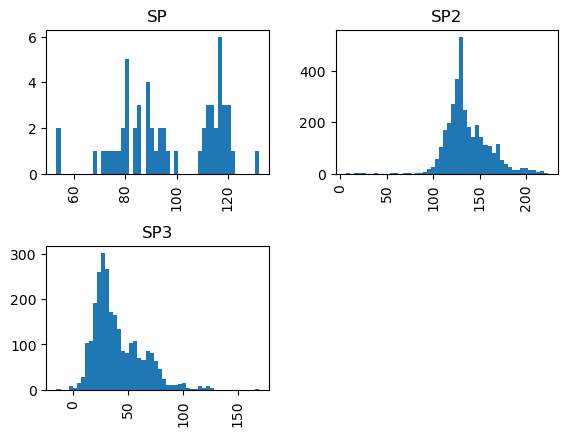

In [52]:
_ = df.hist("shift", by="hybridization", bins=50)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
      dtype=object)

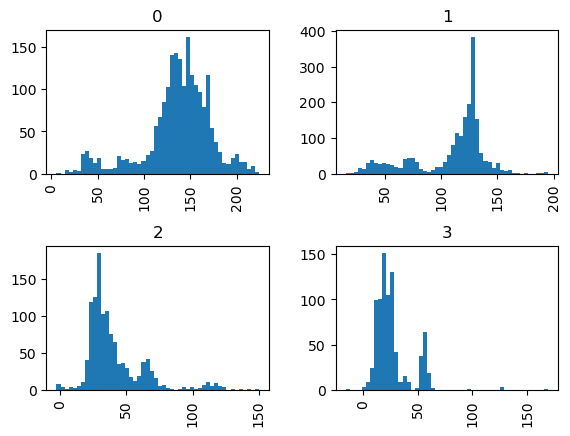

In [53]:
df.hist("shift", by="numHs", bins=50)

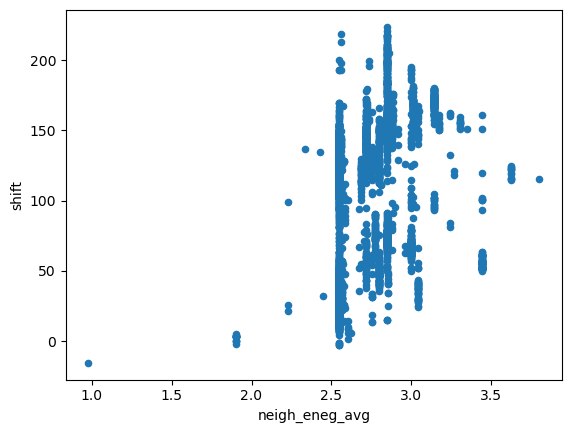

In [64]:
_ = df.plot.scatter("neigh_eneg_avg", "shift")

In [124]:
data = df.drop(["shift"], axis=1)
target = df["shift"]

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(transformers=[('hybridization_encoder', OneHotEncoder(), ["hybridization"])], remainder='passthrough')

model = Pipeline(steps=[("preprocessor", transformer), ("scaling", StandardScaler()), ("regression", LinearRegression())])
model.fit(data, target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('hybridization_encoder',
                                                  OneHotEncoder(),
                                                  ['hybridization'])])),
                ('scaling', StandardScaler()),
                ('regression', LinearRegression())])

In [125]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(target, model.predict(data))

8.482993722045139

In [130]:
model.named_steps["regression"].coef_

array([-1.86988499e+12, -9.54185848e+12, -9.52151330e+12, -5.54781249e-04,
       -2.11600546e+00, -9.99522829e+00,  1.46484375e-03,  4.94003128e+00,
       -1.96396877e+01, -1.86181290e+00,  1.85932255e+01, -1.66592416e+00,
        3.90911130e+00,  1.53241382e-01, -3.61292331e+00,  3.93417609e+01,
       -4.92505909e+01,  1.56196555e+01,  3.92751221e+01,  9.14555578e-01,
        4.78254791e+00,  3.86391592e+00,  6.84357046e+00, -1.43115134e+01,
        8.10449548e+00, -6.97250349e-01, -1.61169605e+01])

In [131]:
from sklearn.model_selection import cross_validate

cross_validate(model, data, target, scoring="neg_mean_absolute_error", return_train_score=True)

{'fit_time': array([0.02667308, 0.01837182, 0.01438975, 0.01378512, 0.01346421]),
 'score_time': array([0.0036931 , 0.0033772 , 0.00258398, 0.00258803, 0.00242615]),
 'test_score': array([-8.83182244, -8.81089136, -8.3804404 , -7.87895065, -9.25263324]),
 'train_score': array([-8.43495774, -8.39098858, -8.59922225, -8.6631024 , -8.2955986 ])}

In [132]:
from sklearn.linear_model import Ridge

model2 = Pipeline(steps=[("preprocessor", transformer), ("scaling", StandardScaler()), ("regression", Ridge())])
model2.fit(data, target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('hybridization_encoder',
                                                  OneHotEncoder(),
                                                  ['hybridization'])])),
                ('scaling', StandardScaler()), ('regression', Ridge())])

In [135]:
mean_absolute_error(target, model2.predict(data))

8.484773924629723

In [136]:
model2.named_steps["regression"].coef_

array([-4.07988694e-01,  2.19342142e+01, -2.19009594e+01,  3.40739261e-04,
       -3.06929043e+00, -9.90374986e+00,  0.00000000e+00,  3.17960404e+00,
       -1.08929259e+01, -1.11469915e+00,  9.29485441e+00, -9.82542320e-01,
        2.54098150e+00,  2.70138109e-02, -2.16646222e+00,  1.51617001e+01,
       -2.60831307e+01,  1.29281339e+01,  1.83161298e+01,  1.11643404e+00,
        4.44103155e+00,  3.73610548e+00,  7.18767463e+00, -9.34501714e+00,
        5.28961116e+00, -4.85013078e-01, -1.07822547e+01])

<Axes: >

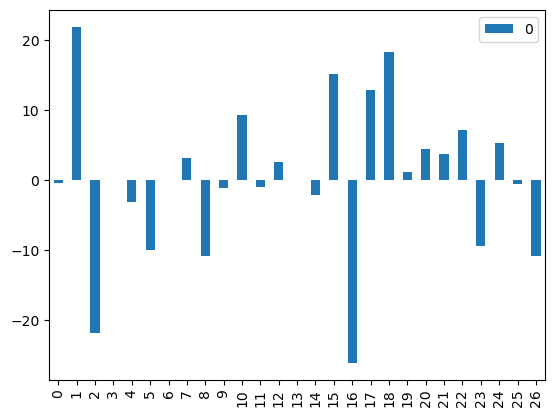

In [149]:
pd.DataFrame(model2.named_steps["regression"].coef_).plot.bar()

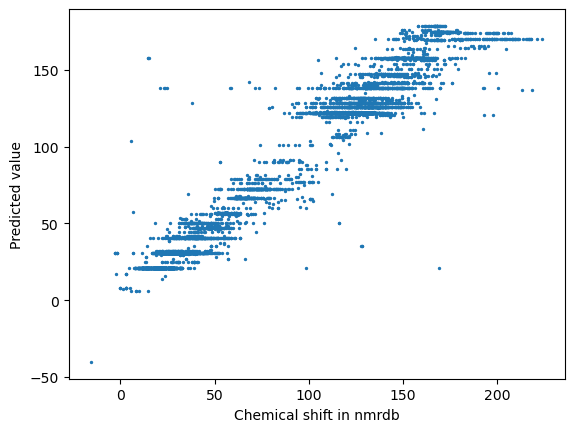

In [158]:
ax = pd.DataFrame({"x": target, "y": model2.predict(data)}).plot.scatter("x", "y", s=2)
ax.set_xlabel("Chemical shift in nmrdb")
ax.set_ylabel("Predicted value");

## To go further

- Effet of solvent, very important
- Nature of the model: are linear models best?
- What is the impact of quantity of available data?
- Quantifying further neighbors: hand-made, or atom-based fingerprints
- Instead of neighbor statistics, try group contributions